<a href="https://colab.research.google.com/github/jacksontabors/Getting_Into_Business/blob/main/Tabors_getting_into_business_deliverable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Data Set Path**

In [8]:
import kagglehub

path = kagglehub.dataset_download("fratzcan/usa-house-prices")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/fratzcan/usa-house-prices/versions/1


**Load the File**

In [11]:
files = os.listdir(path)
csv_files = [file for file in files if file.endswith(".csv")]
data = pd.read_csv(os.path.join(path, csv_files[0]))

**Question Responses**



*   When was the data acquired? -
  The data was gathered over the period of time from May to July of 2017. The data was uploaded to Kaggle and was most recently updated on January 24, 2018. For the purposes of this analysis, the data was accessed on Kaggle.com on February 26, 2025
  
*  Where was the data acquired? -
The team that performed the analysis in this report accessed the data used in this report via Kaggle.com. The data was uploaded to Kaggle from Zillow. Zillow acquired the data through public and proprietary sources from across the United States.


*   How was the data acquired? -
Zillow’s Economic Research Team collects, cleans, and publishes housing and economic data from a variety of public and proprietary sources. The foundation of Zillow’s data lies on public property record data filed
with local municipalities. This includes deeds, property facts, parcel information, and transactional histories. Much of the data found in these data sets are statistics calculated from raw property data. The methodology
behind those calculations is further explained in the following section where the attributes are described.

*   What are the atributes of this dataset? -
The Zillow Economics Data dataset contains eight sub-datasets each with slightly different attributes. In this section, we will present the attributes that appear in multiple sub-datasets. Then, in following sections we specify the exact attributes contained in the corresponding sub-dataset.

*   The data set includes three vairables that are expressed in an numerical group (price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, sqft_above, sqft_basement, yr_built, yr_renovated). There is also categorical variables in (date, street, city, statezip, country). There are no oerdinals in this data set.






**Data Types Discovery**

In [12]:
print("Columns and Their Data Types:")
print(data.dtypes)

Columns and Their Data Types:
date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
street            object
city              object
statezip          object
country           object
dtype: object


In [13]:
import pandas as pd
import os
def classify_column_types(df):
    types = {'Numerical': [], 'Categorical': [], 'Ordinal (possible)': []}

    for col in df.columns:
        unique_vals = df[col].dropna().unique()
        n_unique = len(unique_vals)
        dtype = df[col].dtype

        # Numerical columns
        if pd.api.types.is_numeric_dtype(df[col]):
            types['Numerical'].append(col)

        # Datetime columns — not truly categorical or numerical
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            continue  # You can create a separate "Datetime" bucket if you want

        # Object or category types
        elif pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
            if n_unique < 20:
                # Guess ordinal if values are ordered strings (e.g. "Low", "Medium", "High")
                ordered_keywords = ['low', 'medium', 'high', 'small', 'medium', 'large', 'poor', 'fair', 'good', 'excellent']
                values_lower = [str(v).lower() for v in unique_vals]
                if any(word in val for val in values_lower for word in ordered_keywords):
                    types['Ordinal (possible)'].append(col)
                else:
                    types['Categorical'].append(col)
            else:
                types['Categorical'].append(col)

    return types

# Apply classification
column_types = classify_column_types(data)

# Print results
print("Column Type Classification:\n")
for col_type, cols in column_types.items():
    print(f"{col_type} Columns ({len(cols)}):")
    print(cols)
    print()


Column Type Classification:

Numerical Columns (13):
['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']

Categorical Columns (5):
['date', 'street', 'city', 'statezip', 'country']

Ordinal (possible) Columns (0):
[]



**Date Range Discovery**

In [14]:
# Identify potential date columns (object or datetime types)
date_columns = data.select_dtypes(include=['object', 'datetime']).columns

# Try converting object columns to datetime (if not already converted)
for col in date_columns:
    try:
        data[col] = pd.to_datetime(data[col])
        print(f"Converted '{col}' to datetime format.")
    except Exception:
        pass  # Skip columns that can't be converted

# Find the actual date column (assuming there is one)
date_col = None
for col in date_columns:
    if pd.api.types.is_datetime64_any_dtype(data[col]):
        date_col = col
        break

# Display the range if a date column is found
if date_col:
    min_date = data[date_col].min()
    max_date = data[date_col].max()
    print(f"Date Range in '{date_col}': {min_date} to {max_date}")
else:
    print("No valid date column found in the dataset.")


Converted 'date' to datetime format.
Date Range in 'date': 2014-05-02 00:00:00 to 2014-07-10 00:00:00


<ipython-input-14-ee83a05be9f1>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col])
<ipython-input-14-ee83a05be9f1>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col])
<ipython-input-14-ee83a05be9f1>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col])


**Splittin types of Vaiables and Summary Statistic Generation**

In [17]:
def generate_clean_summaries(df):
    numerical_stats = []
    ordinal_stats = []
    categorical_stats = []
    datetime_stats = []

    ordinal_keywords = ['low', 'medium', 'high', 'poor', 'fair', 'good', 'excellent', 'small', 'large']

    for col in df.columns:
        series = df[col].dropna()
        n_missing = df[col].isnull().sum()
        dtype = series.dtype

        if pd.api.types.is_numeric_dtype(series):
            numerical_stats.append({
                'Column': col,
                'Mean': round(series.mean(), 2),
                'Median': round(series.median(), 2),
                'Mode': series.mode().iloc[0] if not series.mode().empty else None,
                'Min': series.min(),
                'Max': series.max(),
                'Std Dev': round(series.std(), 2),
                'Missing Values': n_missing
            })

        elif pd.api.types.is_datetime64_any_dtype(series):
            datetime_stats.append({
                'Column': col,
                'Min Date': series.min(),
                'Max Date': series.max(),
                'Missing Values': n_missing
            })

        elif pd.api.types.is_object_dtype(series) or pd.api.types.is_categorical_dtype(series):
            unique_vals = series.unique()
            values_lower = [str(v).lower() for v in unique_vals]

            is_ordinal = any(any(word in val for word in ordinal_keywords) for val in values_lower)

            if is_ordinal:
                ordinal_stats.append({
                    'Column': col,
                    'Mode': series.mode().iloc[0] if not series.mode().empty else None,
                    'Unique Values': len(series.unique()),
                    'Missing Values': n_missing
                })
            else:
                categorical_stats.append({
                    'Column': col,
                    'Mode': series.mode().iloc[0] if not series.mode().empty else None,
                    'Unique Values': len(series.unique()),
                    'Missing Values': n_missing
                })

    # Convert each to a DataFrame
    numerical_df = pd.DataFrame(numerical_stats)
    ordinal_df = pd.DataFrame(ordinal_stats)
    categorical_df = pd.DataFrame(categorical_stats)
    datetime_df = pd.DataFrame(datetime_stats)

    return numerical_df, ordinal_df, categorical_df, datetime_df

# Run the function
numerical_summary, ordinal_summary, categorical_summary, datetime_summary = generate_clean_summaries(data)

# Display summaries
print("📊 Numerical Summary:")
display(numerical_summary)

print("\n🔢 Ordinal Summary (Guessed):")
display(ordinal_summary)

print("\n🔠 Categorical Summary:")
display(categorical_summary)

print("\n📅 Datetime Summary:")
display(datetime_summary)


📊 Numerical Summary:


,Column,Mean,Median,Mode,Min,Max,Std Dev,Missing Values
0,price,553062.88,460000.00,0.0,0.0,26590000.00,583686.45,0
1,bedrooms,3.40,3.00,3.0,0.0,8.00,0.90,0
2,bathrooms,2.16,2.25,2.5,0.0,6.75,0.78,0
3,sqft_living,2143.64,1980.00,1720.0,370.0,10040.00,957.48,0
4,sqft_lot,14697.64,7676.00,5000.0,638.0,1074218.00,35876.84,0
5,floors,1.51,1.50,1.0,1.0,3.50,0.53,0
6,waterfront,0.01,0.00,0.0,0.0,1.00,0.09,0
7,view,0.25,0.00,0.0,0.0,4.00,0.79,0
8,condition,3.45,3.00,3.0,1.0,5.00,0.68,0
9,sqft_above,1831.35,1600.00,1200.0,370.0,8020.00,861.38,0



🔢 Ordinal Summary (Guessed):


,Column,Mode,Unique Values,Missing Values
0,street,2520 Mulberry Walk NE,4079,0



🔠 Categorical Summary:


,Column,Mode,Unique Values,Missing Values
0,city,Seattle,43,0
1,statezip,WA 98103,77,0
2,country,USA,1,0



📅 Datetime Summary:


,Column,Min Date,Max Date,Missing Values
0,date,2014-05-02,2014-07-10,0


**Visual Displays**

**Price vs Square Footage Chart**

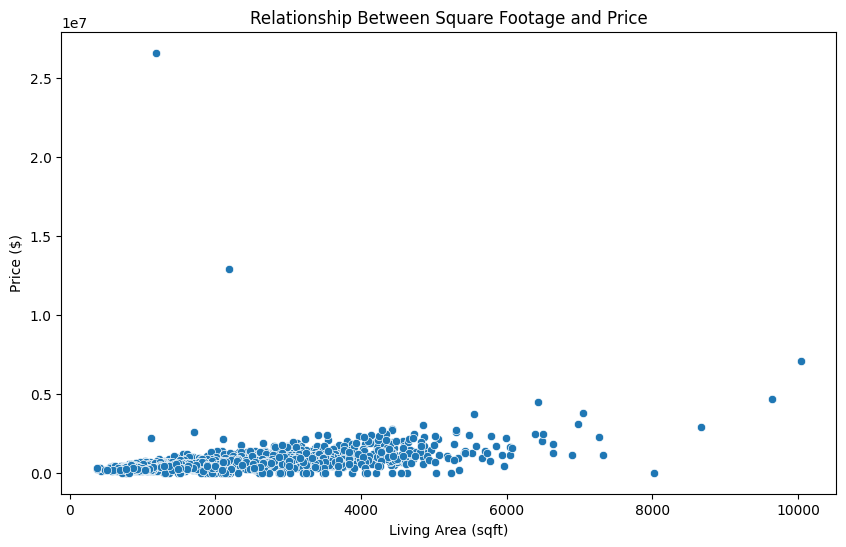

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='sqft_living', y='price')
plt.title('Relationship Between Square Footage and Price')
plt.xlabel('Living Area (sqft)')
plt.ylabel('Price ($)')
plt.show()



This chart shows a postive trend that exists between size of the home and the price of its value. There are a few conradiction and outliers in the chart as well. These will likely be explained by location or zip code of the home as well that is not being account for in this chart.

**Number of bedrooms impact on home prices**

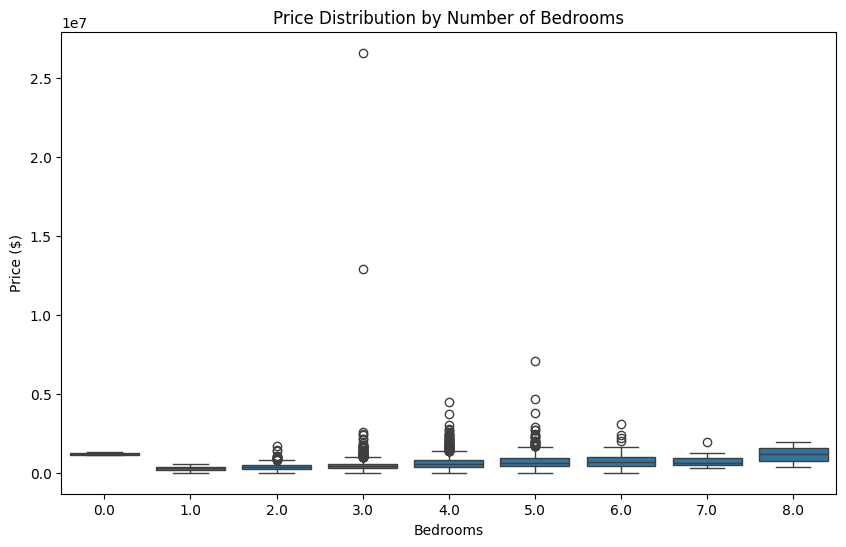

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='bedrooms', y='price')
plt.title('Price Distribution by Number of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Price ($)')
plt.show()



I find that this chart answers a similar question to the one above, while focusing on how price is affected by different aspects of the home. This chart additionally creates a plot that show median 1Q and 3Q which is important to consider. After evaluation, there is a clear upward trend as the number of rooms gets larger, but it doesn't seem to be as staggering as the square footage aspect above.

**Missing Values**

In [ ]:
# Check for missing values
missing_values = data.isnull().sum()

# Filter out columns with no missing values for a cleaner output
missing_values = missing_values[missing_values > 0]

# Display missing values per column
if missing_values.empty:
    print("No missing values in the dataset.")
else:
    print("Missing Values in Dataset:")
    print(missing_values)


This Dataset does not contain any empty or missing values

**Other Data Set**

Other Source to help understanding:

https://www.kaggle.com/datasets/arturdragunov/usa-weekly-real-estate-listings

This dataset would help provide a more fresh perspective on similar real estate numbers. The dataset that I selected is from 2022-2023 which is more recent than the other one from 2014. This would help compliment the original one in the sense that it can show pricing changes almost a decade later. This dataset is also sourced from Redfin primarily which would provide a different perspective from the original dataset as far as where everything is coming from.